In [136]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random

In [137]:
segment_directory = "data/segmentation.csv"
segment = pd.read_csv(segment_directory, header=0)

In [138]:
segment.head()

CustomerId  Monetary     Recency  Frequency  \
0  8b4f8c66-7589-4734-8ada-2d42f60540ab    100.40  2019-06-04          6   
1  2151b2a2-8867-4986-9e00-449c2b4f89e9    170.00  2019-05-25          4   
2  3111db79-6721-4ec0-82b1-30b810649c5e     70.75  2019-05-25          6   
3  9cb76426-cc5d-4fa3-88bc-b92314b9f4e8     75.00  2019-03-20         10   
4  5d86caeb-2d53-44a7-b379-7f15f06ca821     94.51  2019-04-10          5   

   factor_1  factor_2  factor_3  factor_4  
0      0.35      0.08  0.609740  0.949383  
1      0.66      0.16  0.942272  0.479846  
2      0.92      0.20  0.323030  0.007076  
3      0.35      0.78  0.876833  0.088974  
4      0.51      0.44  0.912099  0.206194

In [139]:
segment.describe()

Monetary     Frequency      factor_1      factor_2      factor_3  \
count  16000.000000  16000.000000  16000.000000  16000.000000  16000.000000   
mean     129.972264      3.950687      0.500008      0.497864      0.495451   
std      179.809263      5.189864      0.290144      0.291103      0.289034   
min        0.000000      1.000000      0.000000      0.000000      0.000037   
25%       20.910000      1.000000      0.250000      0.240000      0.242545   
50%       59.275000      2.000000      0.500000      0.500000      0.496410   
75%      170.000000      5.000000      0.750000      0.750000      0.744476   
max     3040.000000    111.000000      1.000000      1.000000      0.999996   

           factor_4  
count  16000.000000  
mean       0.498427  
std        0.288478  
min        0.000033  
25%        0.248739  
50%        0.498833  
75%        0.747424  
max        0.999943

Статистики замаскированных показателей подозрительно напоминают равномерное распределение. Проверим это

In [140]:
from scipy.stats import kstest

kstest(segment.factor_1, 'uniform', args=(0, 1))

KstestResult(statistic=0.011187500000000017, pvalue=0.03644380222640396)

Действительно, распределение factor_1 совсем немного отличается от равномерного распределения. Посмотрим, есть ли зависимость между этими факторами

In [141]:
from sklearn.feature_selection import mutual_info_regression

factors = ['factor_1', 'factor_2', 'factor_3', 'factor_4']

max_depencency = 0
for i in range(len(factors)):
    for j in range(i + 1, len(factors)):
        dep = mutual_info_regression(segment[factors[j]].values.reshape(-1, 1), segment[factors[i]])[0]
        max_depencency = max(max_depencency, dep)

max_depencency

0.012786917699577849

Как можно видеть, все эти факторы попарно слабо зависят друг от друга, из чего можно сделать вывод, что все замаскированные факторы - независимые равномерно распеределенные случайные величины, нет смысла их рассматривать

In [142]:
segment = segment.drop(['factor_1', 'factor_2', 'factor_3', 'factor_4'], axis=1)

In [143]:
pca = PCA(n_components=1)
pca_result = pca.fit_transform(segment[['Monetary' ,'Frequency']].values)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_[0]))

Explained variation per principal component: 0.9995814955765738


Можно видеть, что главная компонента описывает 99.96% информации, это значит, что признаки Monetary и Frequency можно выразить через один признак

In [144]:
segment['Worth'] = pca_result[:, 0]
# segment = segment.drop(['Monetary' ,'Frequency'], axis=1)

In [145]:
segment.groupby(segment.Recency).count().shape

(167, 5)

В наборе данных всего 167 различных дат, можем закодировать их для использования в кластеризации. В полученном наборе датам будет соответствовать числа от 0 (самая ранняя дата) до 167 (самая недавняя дата) 

In [146]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
dates = segment.groupby(segment.Recency).count().index.tolist()
enc.fit(dates)

segment.Recency = enc.transform(segment.Recency)

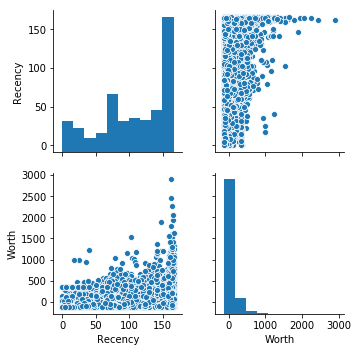

In [147]:
sns.pairplot(segment.drop(['Monetary' ,'Frequency'], axis=1))

Можно заметить, что тем позже был сделан последний платеж, тем меньше вклад пользователя. Также можно видеть, что почти все особенно крупные значения вкладов у тех, кто совершал платежи совсем недавно.

Видно, что на распределении показателей нет четкого разделения на категории, однако можно заметить, что по значимости большая часть значений лежит в промежутке до 300, тогда как некоторые значения доходят до 3000.

Попробуем разделить пользователей на кластеры по этим двум параметрам

In [211]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4).fit(segment[['Worth', 'Recency']])
segment["Group"] = kmeans.labels_

Наилучшее выделение групп было получено при делении на 4 кластера.

При делении на большее количество кластеров, кластер основной массы пользователей не менялся, в то время как небольшие кластеры продолжали фрагментироваться, не давая новой информации.

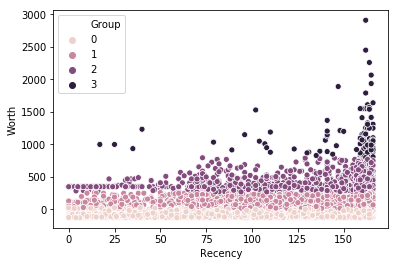

In [212]:
sns.scatterplot(x="Recency", y="Worth", data=segment, hue="Group")

Порядок следования групп не очень логичен с точки зрения анализа результатов - отсортируем его по возрастанию вклада

In [213]:
def reorder_asc(group, sort_column):
    order_map = {
        j: i for i, (j, _) in enumerate(
            sorted(
                enumerate(segment.groupby(group)[sort_column].mean()),
                key=lambda x: x[1]))}
    
    def _reorder(row):
        return order_map[row[group]]
    return _reorder

segment["Group"] = segment.apply(reorder_asc("Group", "Worth"), axis=1)

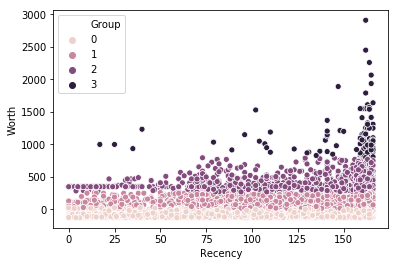

In [214]:
sns.scatterplot(x="Recency", y="Worth", data=segment, hue="Group")

In [215]:
gr = segment.groupby('Group')
gr.Monetary.describe()

count         mean         std     min      25%      50%      75%  \
Group                                                                        
0      11467.0    45.462285   37.584588    0.00    14.42    32.39    63.01   
1       3234.0   242.045043   71.052687  136.31   185.00   230.00   290.00   
2       1208.0   543.599313  119.061056  393.51   460.00   500.00   600.00   
3         91.0  1305.478681  375.733039  930.00  1050.00  1195.00  1382.50   

           max  
Group           
0       161.05  
1       392.52  
2       925.00  
3      3040.00

In [216]:
gr.Frequency.describe()

count       mean        std  min   25%   50%   75%    max
Group                                                             
0      11467.0   2.293712   1.778478  1.0   1.0   2.0   3.0   17.0
1       3234.0   6.448052   4.227514  1.0   4.0   5.0   8.0   57.0
2       1208.0  10.755795   9.315378  1.0   4.0   8.0  16.0   54.0
3         91.0  33.659341  22.168656  5.0  16.5  27.0  47.0  111.0

In [217]:
gr.Recency.describe()

count        mean        std   min    25%    50%    75%    max
Group                                                                  
0      11467.0   98.217581  52.047916   0.0   66.0  101.0  149.0  166.0
1       3234.0  128.743661  41.121362   0.0   98.0  149.0  160.0  166.0
2       1208.0  130.719371  42.134179   0.0  107.0  151.0  161.0  166.0
3         91.0  146.703297  32.225419  17.0  141.0  161.0  164.0  166.0

In [219]:
gr.Monetary.sum()

Group
0    521316.02
1    782773.67
2    656667.97
3    118798.56
Name: Monetary, dtype: float64

Группы 1 и 2 достаточно схожи по своим показателям, поэтому будем рассматривать их как одну группу.

Можно заметить, что основная масса пользователей попала в группу 0 - это пользователи, которые в среднем не часто вносят платежи, следовательно вносят небольшой объем средств. Также в среднем они вносят платежи менее регулярно. Несмотря на значительный объем группы, суммарно эти пользователи привносят меньше чем пользователи групп 1 и 2

Пользователи групп 1 и 2 - это активные пользователи. Они достаточно регулярно вносят платежи, за рассматриваемый период они внесли с среднем 6-10 платежей. Именно пользователи этих групп вносят основной вклад: их втрое меньше, чем пользователей первой группы, но они привнесли в ~2.5 больше средств

Пользователи группы 3 - это особенно активные пользователи. Их достаточно мало, менее 1%, но они вносят платежи значительно чаще остальных (в среднем 30 раз за рассматриваемый период). Однако в силу малочисленности их общий вклад достаточно невелик